# Model Selection

In [164]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split

In [7]:
import gymnasium as gym
import math
import matplotlib
import matplotlib.pyplot as plt
from itertools import count

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from tqdm import tqdm
from sympy import isprime  # Reliable primality test

In [4]:
updated_data = pd.read_csv("../Data/updated_data.csv")
updated_data = shuffle(updated_data)

In [384]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [71]:
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

## Example DQN Model From Pytorch

In [7]:
env = gym.make("CartPole-v1")

In [10]:
# Replay Memory Construction
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [11]:
#Q-Network
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [12]:
#Hyper Parameters
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [13]:
# Optimizer
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


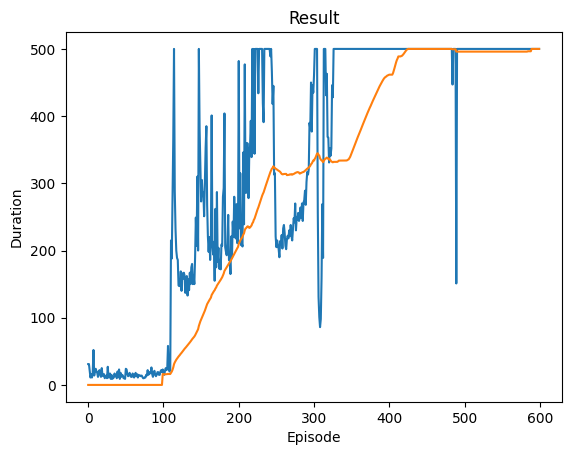

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
#Main Loop
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

## Custom Environment & DQN Model Trial

In [302]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [303]:
updated_data = pd.read_csv("../Data/updated_data.csv")

In [304]:
updated_data, test_data = train_test_split(updated_data, test_size=0.2, random_state=42)

In [305]:
# Define Q-network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Q-values for all actions

In [306]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).to(device),
            torch.tensor(rewards, dtype=torch.float32).to(device),
            torch.tensor(next_states, dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).to(device),
        )

    def __len__(self):
        return len(self.buffer)

In [307]:
# Reward Mechanism (Checks only for primality)
def calculate_reward(state):
    binary_state = [int(bit) for bit in state]
    number = int(''.join(map(str, binary_state)), 2)
    if isprime(number):
        return 1  # Reward for primes
    else : 
        return 0
    # # Penalize non-primes based on divisors
    # penalty = sum([1 for i in range(2, int(number**0.5) + 1) if number % i == 0])

In [308]:
def pretrain_q_network_with_primes(q_network, optimizer, dataset, num_epochs=10, log_interval=100):
   
    q_network.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        total_loss = 0  # Track cumulative loss for the epoch
        prime_count = 0  # Track the number of prime states used

        for i, (_, row) in enumerate(tqdm(dataset.iterrows(), total=len(dataset), desc=f"Epoch {epoch + 1}/{num_epochs}")):
            # Extract binary state representation from the dataset
            state = row[['bit19', 'bit18', 'bit17', 'bit16', 'bit15',
                         'bit14', 'bit13', 'bit12', 'bit11', 'bit10',
                         'bit9', 'bit8', 'bit7', 'bit6', 'bit5',
                         'bit4', 'bit3', 'bit2', 'bit1', 'bit0']].values.tolist()

            reward = calculate_reward(state)  # Calculate reward (should be 1 for prime states)
            if reward <= 0:
                continue  # Skip non-prime states; only use primes for pretraining

            prime_count += 1

            # Prepare input tensor for the Q-network
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            # Calculate target Q-values: Assign high reward (e.g., 1) for all actions
            target = torch.full((1, 20), reward, dtype=torch.float32).to(device)

            # Compute loss and backpropagate
            loss = nn.MSELoss()(q_network(state_tensor), target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Log progress periodically
            if (i + 1) % log_interval == 0:
                print(f"Batch {i + 1}: Loss = {total_loss / (i + 1):.4f}, Primes Processed = {prime_count}")

        print(f"Epoch {epoch + 1}/{num_epochs} completed. Total Loss: {total_loss:.4f}, Primes Processed: {prime_count}")


In [309]:
def populate_replay_buffer_from_dataset(dataset, replay_buffer):
    for _, row in dataset.iterrows():
        state = row[['bit19', 'bit18', 'bit17', 'bit16', 'bit15',
                     'bit14', 'bit13', 'bit12', 'bit11', 'bit10',
                     'bit9', 'bit8', 'bit7', 'bit6', 'bit5',
                     'bit4', 'bit3', 'bit2', 'bit1', 'bit0']].values.tolist()

        for action in range(20):
            next_state = state.copy()
            next_state[action] = 1 - next_state[action]
            reward = calculate_reward(next_state)
            done = reward > 0
            replay_buffer.store(state, action, reward, next_state, done)

        if len(replay_buffer) >= replay_buffer.buffer.maxlen:
            break


In [310]:
# Epsilon-Greedy Policy
def epsilon_greedy_policy(state, q_network, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 19)
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = q_network(state_tensor)
        return q_values.argmax().item()

In [311]:
# Train Q-Network
def train_q_network(q_network, target_network, optimizer, replay_buffer, batch_size, gamma=0.99):
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    q_values = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        max_next_q_values = target_network(next_states).max(1)[0]
        target_q_values = rewards + gamma * max_next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [312]:
from tqdm import tqdm  # For progress visualization

def evaluate_model(q_network, num_episodes=1000):
    q_network.eval()  # Set the model to evaluation mode
    successful_episodes = 0
    rewards = []  # Track rewards per episode
    step_logs = []  # Log details for debugging
    success_rates = []  # Initialize success rates for graph
    reward_summaries = []  # Initialize reward summaries for graph
    batch_size = 100  # Batches for logging progress

    print("\nStarting Evaluation...")
    for episode in tqdm(range(1, num_episodes + 1), desc="Evaluating Episodes"):
        state = [random.randint(0, 1) for _ in range(state_size)]  # Start with a randomized binary state
        done = False
        episode_reward = 0  # Cumulative reward for the episode
        steps = 0  # Track the number of steps

        while not done and steps < 100:  # Limit steps to avoid infinite loops
            steps += 1

            # Compute Q-values and select the best action
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                q_values = q_network(state_tensor)
            action = q_values.argmax().item()

            # Perform the action (flip the bit)
            next_state = state.copy()
            next_state[action] = 1 - next_state[action]
            reward = calculate_reward(next_state)
            done = reward > 0  # Stop if a prime is found
            episode_reward += reward

            # Update the state
            state = next_state

        # Track successful episodes
        if done:
            successful_episodes += 1
        rewards.append(episode_reward)

        # Periodically log metrics
        if episode % batch_size == 0:
            avg_success_rate = successful_episodes / episode
            avg_reward = sum(rewards[-batch_size:]) / batch_size
            success_rates.append(avg_success_rate)
            reward_summaries.append(avg_reward)
            print(f"Batch {episode // batch_size}: Success Rate = {avg_success_rate * 100:.2f}%, Avg Reward = {avg_reward:.2f}")

    # Calculate and log final metrics
    success_rate = successful_episodes / num_episodes
    avg_reward = sum(rewards) / num_episodes

    print("\nEvaluation Summary:")
    print(f"Success Rate: {success_rate * 100:.2f}%")
    print(f"Average Reward: {avg_reward:.2f}")

    # Plot success rate and reward progression
    plot_evaluation_metrics(success_rates, reward_summaries, batch_size)

    return success_rate, avg_reward, step_logs

In [313]:
def plot_evaluation_metrics(success_rates, reward_summaries, batch_size):
    episodes = [batch_size * i for i in range(1, len(success_rates) + 1)]

    # Plot Success Rate
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, success_rates, label="Success Rate", marker='o')
    plt.xlabel("Episodes")
    plt.ylabel("Success Rate")
    plt.title("Success Rate Progression During Evaluation")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Average Reward
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, reward_summaries, label="Average Reward", marker='o', color='orange')
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Average Reward Progression During Evaluation")
    plt.grid(True)
    plt.legend()
    plt.show()

In [314]:
# Hyperparameters
state_size = 20  # Each state is represented by a 20-bit number
action_size = 20  # 20 possible actions (flip each bit)
episodes = 1000  # Total number of training episodes
batch_size = 32  # Batch size for replay buffer sampling
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration probability
epsilon_decay = 0.999  # Decay rate for epsilon
min_epsilon = 0.01  # Minimum exploration probability
buffer_size = 10000  # Replay buffer size

# Initialize Q-network and target network
q_network = QNetwork(state_size, action_size).to(device)
target_network = QNetwork(state_size, action_size).to(device)
target_network.load_state_dict(q_network.state_dict())  # Synchronize networks
optimizer = optim.Adam(q_network.parameters(), lr=0.0001)  # Optimizer for Q-network

In [315]:
# # Pretraining
print("Pretraining the Q-network...")
pretrain_q_network(q_network, optimizer, updated_data, num_epochs=3, log_interval=500)

Pretraining the Q-network...


Epoch 1/3: 100%|████████████████████████████████████████████████████████████████| 65620/65620 [04:01<00:00, 271.16it/s]


Epoch 1/3 completed. Total Loss: 5811.0612


Epoch 2/3: 100%|████████████████████████████████████████████████████████████████| 65620/65620 [03:54<00:00, 279.34it/s]


Epoch 2/3 completed. Total Loss: 5791.1212


Epoch 3/3: 100%|████████████████████████████████████████████████████████████████| 65620/65620 [03:40<00:00, 298.03it/s]

Epoch 3/3 completed. Total Loss: 5784.9817


In [316]:
# Initialize Replay Buffer
replay_buffer = ReplayBuffer(max_size=buffer_size)
#populate_replay_buffer_from_dataset(updated_data, replay_buffer)  # Populate with dataset


Starting Evaluation...


Evaluating Episodes:  11%|██████▏                                                   | 106/1000 [00:03<00:26, 33.36it/s]

Batch 1: Success Rate = 16.00%, Avg Reward = 0.16


Evaluating Episodes:  20%|███████████▊                                              | 203/1000 [00:05<00:26, 30.41it/s]

Batch 2: Success Rate = 17.00%, Avg Reward = 0.18


Evaluating Episodes:  30%|█████████████████▋                                        | 305/1000 [00:08<00:18, 36.79it/s]

Batch 3: Success Rate = 20.33%, Avg Reward = 0.27


Evaluating Episodes:  40%|███████████████████████▎                                  | 403/1000 [00:11<00:17, 34.17it/s]

Batch 4: Success Rate = 20.00%, Avg Reward = 0.19


Evaluating Episodes:  50%|█████████████████████████████                             | 502/1000 [00:14<00:15, 32.53it/s]

Batch 5: Success Rate = 19.00%, Avg Reward = 0.15


Evaluating Episodes:  61%|███████████████████████████████████▎                      | 608/1000 [00:17<00:11, 35.57it/s]

Batch 6: Success Rate = 17.83%, Avg Reward = 0.12


Evaluating Episodes:  71%|█████████████████████████████████████████                 | 707/1000 [00:20<00:05, 52.83it/s]

Batch 7: Success Rate = 19.29%, Avg Reward = 0.28


Evaluating Episodes:  80%|██████████████████████████████████████████████▋           | 805/1000 [00:23<00:06, 32.13it/s]

Batch 8: Success Rate = 19.38%, Avg Reward = 0.20


Evaluating Episodes:  90%|████████████████████████████████████████████████████▍     | 904/1000 [00:25<00:02, 36.99it/s]

Batch 9: Success Rate = 19.78%, Avg Reward = 0.23


Evaluating Episodes: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.54it/s]


Batch 10: Success Rate = 19.20%, Avg Reward = 0.14

Evaluation Summary:
Success Rate: 19.20%
Average Reward: 0.19


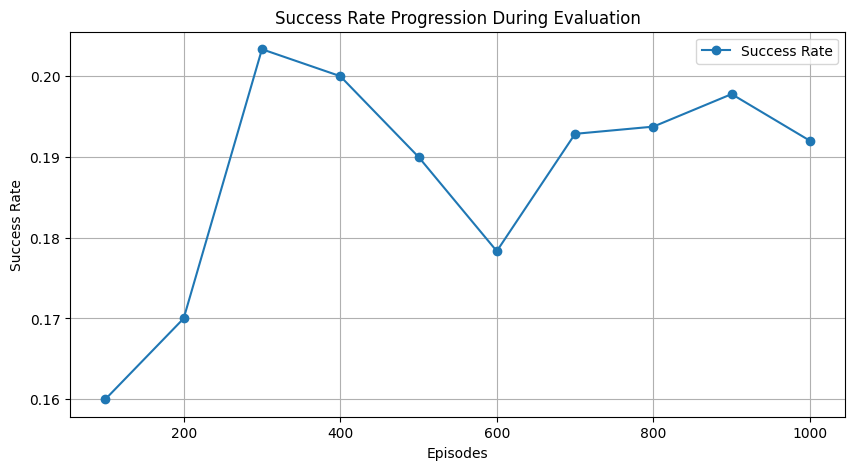

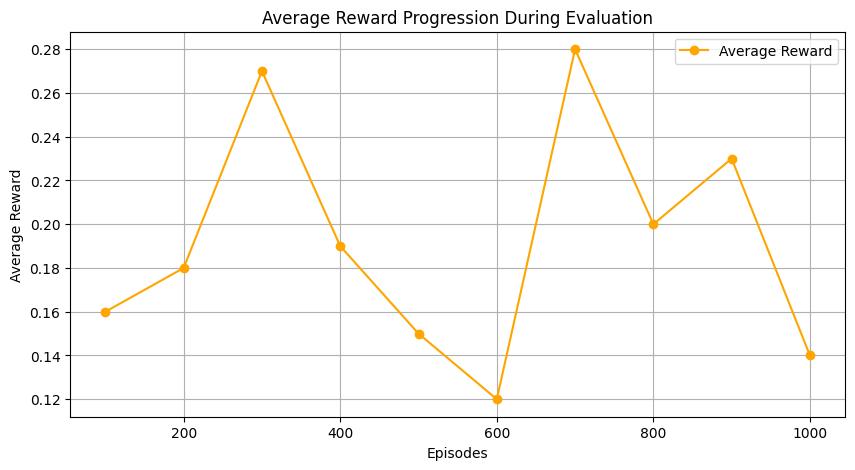

Success Rate: 19.20%
Average Reward: 0.19


In [317]:
# Evaluate pretrained the model
success_rate, avg_reward, logs = evaluate_model(q_network, num_episodes=1000)
print(f"Success Rate: {success_rate * 100:.2f}%")
print(f"Average Reward: {avg_reward:.2f}")

In [318]:
# Training Loop

print(f"Replay Buffer Size: {len(replay_buffer)}")

# Training Loop
print("\nStarting Reinforcement Learning Training...")
for episode in range(episodes):
    state = [random.randint(0, 1) for _ in range(state_size)]   # Start with a zeroed binary state
    done = False
    total_reward = 0  # Track total reward for the episode
    steps = 0  # Track the number of steps in the episode

    while not done and steps < 100:  # Limit steps to avoid infinite loops
        steps += 1

        # Choose an action using epsilon-greedy policy
        action = epsilon_greedy_policy(state, q_network, epsilon)

        # Execute the action (flip the bit)
        next_state = state.copy()
        next_state[action] = 1 - next_state[action]

        # Calculate reward and check if the episode is done
        reward = calculate_reward(next_state)
        done = reward > 0  # Done if a prime number is generated
        total_reward += reward

        # Store the transition in the replay buffer
        replay_buffer.store(state, action, reward, next_state, done)

        # Train the Q-network
        train_q_network(q_network, target_network, optimizer, replay_buffer, batch_size, gamma)

        # Update the state
        state = next_state

    # Decay epsilon (exploration probability)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Periodically update the target network
    if episode % 10 == 0:
        target_network.load_state_dict(q_network.state_dict())

    # Log progress
    print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}, Steps: {steps}")

Replay Buffer Size: 0

Starting Reinforcement Learning Training...
Episode 1/1000, Total Reward: 1, Epsilon: 1.00, Steps: 23
Episode 2/1000, Total Reward: 1, Epsilon: 1.00, Steps: 6
Episode 3/1000, Total Reward: 1, Epsilon: 1.00, Steps: 52
Episode 4/1000, Total Reward: 1, Epsilon: 1.00, Steps: 8
Episode 5/1000, Total Reward: 1, Epsilon: 1.00, Steps: 6
Episode 6/1000, Total Reward: 1, Epsilon: 0.99, Steps: 25
Episode 7/1000, Total Reward: 1, Epsilon: 0.99, Steps: 13
Episode 8/1000, Total Reward: 0, Epsilon: 0.99, Steps: 100
Episode 9/1000, Total Reward: 1, Epsilon: 0.99, Steps: 12
Episode 10/1000, Total Reward: 1, Epsilon: 0.99, Steps: 4
Episode 11/1000, Total Reward: 1, Epsilon: 0.99, Steps: 7
Episode 12/1000, Total Reward: 1, Epsilon: 0.99, Steps: 3
Episode 13/1000, Total Reward: 1, Epsilon: 0.99, Steps: 7
Episode 14/1000, Total Reward: 1, Epsilon: 0.99, Steps: 30
Episode 15/1000, Total Reward: 1, Epsilon: 0.99, Steps: 8
Episode 16/1000, Total Reward: 1, Epsilon: 0.98, Steps: 68
Episo

In [319]:
torch.save(q_network.state_dict(), "../Models/dqn_model_primality_only.pth")

In [320]:
# Run and Show The Evaluation Results
q_network = QNetwork(state_size, action_size).to(device)
q_network.load_state_dict(torch.load("../Models/dqn_model_primality_only.pth"))
q_network = q_network.to(device)
q_network.eval()  # Set to evaluation mode

C:\Users\mberk\AppData\Local\Temp\ipykernel_11456\1494719421.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_network.load_state_dict(torch.load("../Models/dqn_model_pr

QNetwork(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=20, bias=True)
)


Starting Evaluation...


Evaluating Episodes:  10%|██████                                                    | 104/1000 [00:03<00:31, 28.27it/s]

Batch 1: Success Rate = 9.00%, Avg Reward = 0.09


Evaluating Episodes:  20%|███████████▊                                              | 204/1000 [00:06<00:29, 27.03it/s]

Batch 2: Success Rate = 9.50%, Avg Reward = 0.10


Evaluating Episodes:  30%|█████████████████▋                                        | 304/1000 [00:10<00:21, 32.29it/s]

Batch 3: Success Rate = 10.33%, Avg Reward = 0.12


Evaluating Episodes:  40%|███████████████████████▍                                  | 405/1000 [00:13<00:19, 31.24it/s]

Batch 4: Success Rate = 10.25%, Avg Reward = 0.10


Evaluating Episodes:  50%|█████████████████████████████▏                            | 504/1000 [00:16<00:16, 30.45it/s]

Batch 5: Success Rate = 11.20%, Avg Reward = 0.15


Evaluating Episodes:  60%|███████████████████████████████████                       | 604/1000 [00:19<00:14, 28.19it/s]

Batch 6: Success Rate = 10.83%, Avg Reward = 0.09


Evaluating Episodes:  70%|████████████████████████████████████████▊                 | 704/1000 [00:22<00:08, 36.60it/s]

Batch 7: Success Rate = 10.57%, Avg Reward = 0.09


Evaluating Episodes:  80%|██████████████████████████████████████████████▌           | 802/1000 [00:25<00:06, 30.78it/s]

Batch 8: Success Rate = 10.62%, Avg Reward = 0.11


Evaluating Episodes:  90%|████████████████████████████████████████████████████▍     | 905/1000 [00:29<00:03, 28.11it/s]

Batch 9: Success Rate = 10.00%, Avg Reward = 0.05


Evaluating Episodes: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.70it/s]

Batch 10: Success Rate = 9.80%, Avg Reward = 0.08

Evaluation Summary:
Success Rate: 9.80%
Average Reward: 0.10


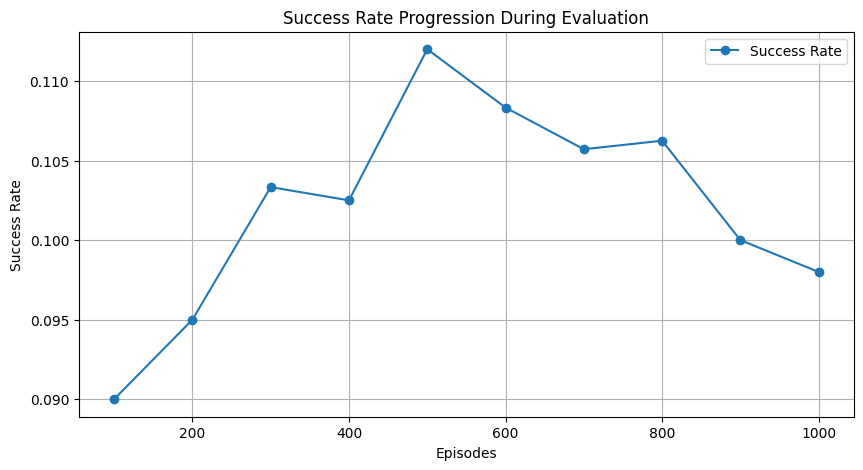

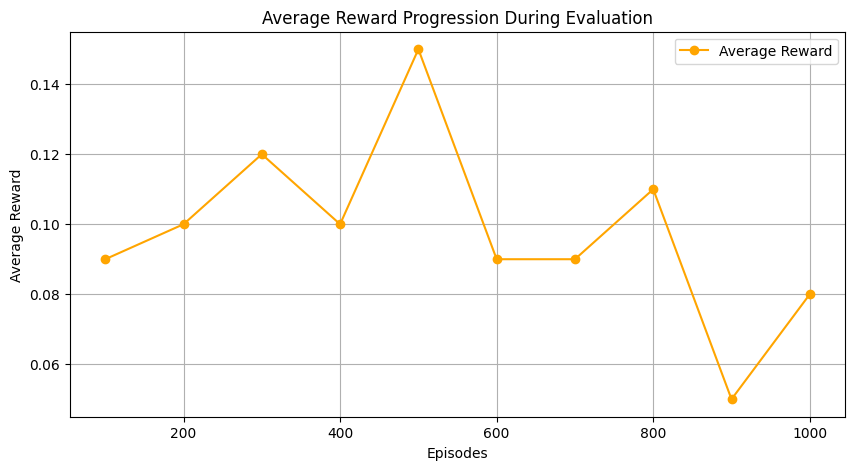

Success Rate: 9.80%
Average Reward: 0.10


In [321]:
# Evaluate the model
success_rate, avg_reward, logs = evaluate_model(q_network, num_episodes=1000)
print(f"Success Rate: {success_rate * 100:.2f}%")
print(f"Average Reward: {avg_reward:.2f}")